# Homework 3 - Linear and Logistic Regressions
## CSCI 4622 - Fall 2021
***
**Name**: $<$Tamer Shahwan$>$
***

This assignment is due on Canvas by **11.59 PM on Monday, November 1st**.
Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle, gzip
%matplotlib inline
import time

## Problem 1: Linear Regression (55 points)

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
The objective is then to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-w^T x_i-b||^2 + \alpha||w||^2
\end{align}

where $\mathbf w$ denotes the set of parameters for the linear regression model,
 $\alpha$ is the trade-off regularization parameter, and $N$ the number of samples
The intercept $b$ can also be included in $(x_i)_{i\leq N}$ by appending a constant feature to the data.
You will be using the following data sets:

In [3]:
class CloudData:
    def __init__(self):
        # Data from: https://archive.ics.uci.edu/ml/datasets/Cloud
        data = np.fromfile("data/cloud.data", sep = " ").reshape((1024, 10))
        y = data[:, 6]
        X = np.delete(data, 6, axis = 1)
        
        self.train_x = X[:800]
        self.train_y = y[:800]
        
        self.test_x = X[800:]
        self.test_y = y[800:]
        
class ForestData:
    def __init__(self):
        # Data from: http://archive.ics.uci.edu/ml/datasets/Forest+Fires
        data = pd.read_csv("data/forestfires.csv")
        data = data.sample(frac = 1).reset_index(drop = True).drop(columns = ["month", "day"])
        data["area"] = np.log(data["area"] + 1)
        X = data.drop(columns = "area").values
        y = data["area"].values
        
        self.train_x = X[:400]
        self.train_y = y[:400]
        
        self.test_x = X[400:]
        self.test_y = y[400:]
cloud_data = CloudData()
forest_data = ForestData()

To implement Ridge Regression, We'll use the solver from sklearn module `Ridge`
([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).
- 1.1 [5 points] Complete the `fit` and `evaluate` methods following the docstring description.

In [4]:
from sklearn import linear_model

class Ridge:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha:  regularization parameter
        """
        self.alpha = alpha # our regularization / penalty term for weights
        self._model = linear_model.Ridge(alpha, fit_intercept=True)  # Using sklearn module Ridge

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights.
        X: training features (n_samples, n_features)
        y: target values (n_samples)
        
        RETURN :
            num_nonzero_coeff : number of non-zero coefficients in the model weights
        """
        #Workspace 1.1.a
        #BEGIN 
        #TODO: Fit the ridge model and return the number of non-zero coefficients in the model weights.
        
        #Code here
        #2raise NotImplementedError()
        model=self._model.fit(X,y)
        
        num_nonzero_coeff=np.count_nonzero(model.coef_)
        #END
        return num_nonzero_coeff

    def evaluate(self, test_x, test_y):
        """
        Compute Mean square error (MSE) between the predicted values and the actual values  of the test data
        Parameters
        ----------
        test_x: test features
        test_y: test target

        Returns MSE
        -------
        """
        #Workspace 1.1.b
        #BEGIN
        #TODO: predict based on the test features and return the mean_squared_error        

        #Code here
        prediction=self._model.predict(test_x)
        mean_squared_error=self.mse(test_y,prediction)
        #END 
        return mean_squared_error

    @staticmethod
    def mse(y_true, y_hat):
        return np.mean((y_true-y_hat)**2)

In [5]:
# Tests cell
model =Ridge(1)
non_zero_coef =model.fit(cloud_data.train_x,cloud_data.train_y)
mse = model.evaluate(cloud_data.test_x,cloud_data.test_y)

1.2 [5 points] For each of the datasets, produce 2 plots using `Ridge` :
  - The number non-zero coefficients versus $\alpha$
  - Mean Squared Error (MSE) on test set versus $\alpha$
 
 Use $\alpha = 1, 50, 100, 200, 1000$

In [6]:
alphas = [1, 50, 100, 200, 1000]
#BEGIN Workspace 1.2
result_cloud_mse = []
result_forest_mse= []
result_cloud_coef = []
result_forest_coef= []
#code here
for alpha in alphas:
    model = Ridge(alpha)
    
    result_cloud_coef.append(model.fit(cloud_data.train_x,cloud_data.train_y))
    result_cloud_mse.append(model.evaluate(cloud_data.test_x,cloud_data.test_y))
    
    result_forest_coef.append(model.fit(forest_data.train_x,forest_data.train_y))
    result_forest_mse.append(model.evaluate(forest_data.test_x,forest_data.test_y))
#END Workspace 1.2


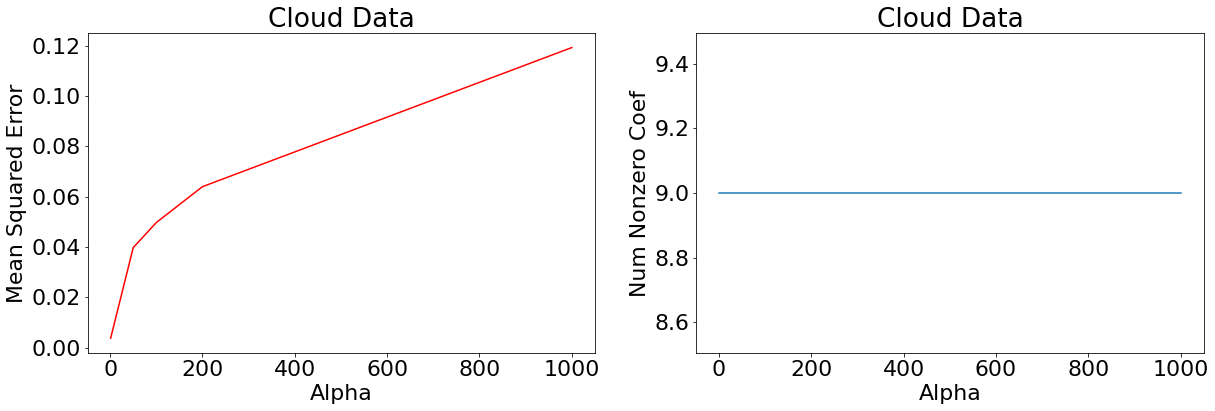

In [7]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 22})
plt.subplot(3,2,1);
plt.ylabel("Mean Squared Error") 
plt.xlabel("Alpha")
plt.title("Cloud Data")
plt.plot(alphas,result_cloud_mse,color = 'red',label="Cloud Data") 

plt.subplot(3,2,2);
plt.ylabel("Num Nonzero Coef") 
plt.xlabel("Alpha")
plt.title("Cloud Data")
plt.plot(alphas,result_cloud_coef,label="Cloud Data")


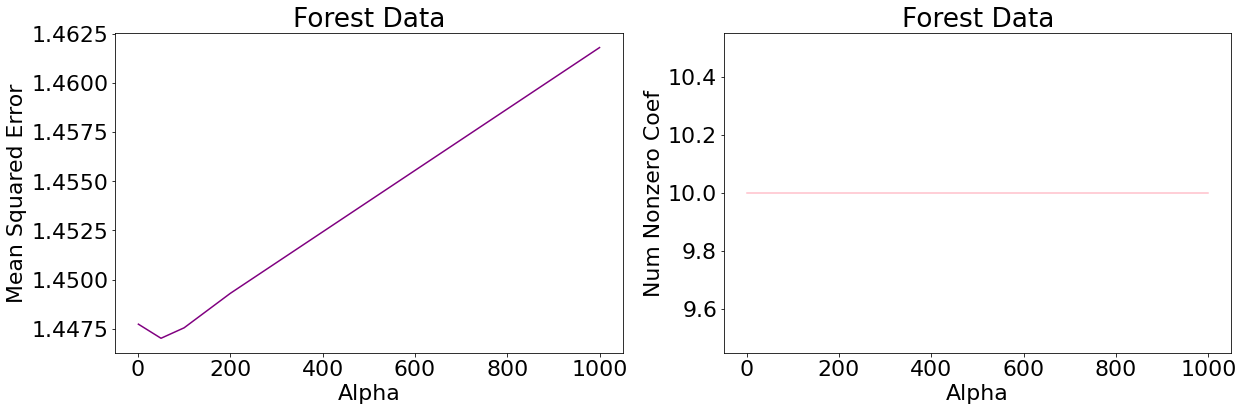

In [8]:
plt.subplot(3,2,3);
plt.ylabel("Mean Squared Error") 
plt.xlabel("Alpha")
plt.title("Forest Data")
plt.plot(alphas,result_forest_mse,color = 'purple',label="Forest Data") 

plt.subplot(3,2,4);
plt.ylabel("Num Nonzero Coef") 
plt.xlabel("Alpha")
plt.title("Forest Data")
plt.plot(alphas,result_forest_coef,color='pink',label="Forest Data")

Now we'll move to Lasso regression. Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-w^t x_i -b||^2 + \alpha||w||_1
\end{align}

We'll be using the `Lasso`solver from sklearn ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).

Complete the Lasso class in the same way as you completed the Ridge class. We'll use the solver from sklearn module `Lasso`
([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).
- 1.3 [5 points] Complete the `fit` and `evaluate` methods following the docstring description.

In [9]:
class Lasso:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha:  regularization parameter
        """                
        self.alpha = alpha
        self._model = linear_model.Lasso(alpha=alpha, fit_intercept=True)

    def fit(self, X, y):
        """
        Fit the Lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights.
        X: training features (n_samples, n_features)
        y: target values (n_samples)
        
        RETURN :
            num_nonzero_coeff : number of non-zero coefficients in the model weights
        """
        #Workspace 1.3.a
        #BEGIN 
        #TODO: Fit the Lasso model and return the number of non-zero coefficients in the model weights.
        
        #Code here
        model = self._model.fit(X,y)
        num_nonzero_coeff = np.count_nonzero(model.coef_)
        #END
        return num_nonzero_coeff

    def evaluate(self, test_x, test_y):
        """
        Compute Mean square error (MSE) between the predicted values and the actual values  of the test data
        Parameters
        ----------
        test_x: test features
        test_y: test target

        Returns MSE
        -------
        """
        #Workspace 1.3.b
        #BEGIN
        #TODO: predict based on the test features and return the mean_squared_error        
        
        #Code here
        prediction=self._model.predict(test_x)
        mean_squared_error=self.mse(test_y,prediction)

        #END 
        return mean_squared_error

    @staticmethod
    def mse(y_true, y_hat):
        return np.mean((y_true-y_hat)**2)

In [10]:
# Tests cell
model =Lasso(1)
model.fit(cloud_data.train_x,cloud_data.train_y)
model.evaluate(cloud_data.test_x,cloud_data.test_y)

0.19833163966389408

1.4 [5 points] For each of the datasets, produce 2 plots using `Lasso` :
  - The number non-zero coefficients versus $\alpha$
  - Mean Squared Error (MSE) on test set versus $\alpha$
 
 Use $\alpha = 0.01, 0.05, 0.1, 0.2, 0.3$

In [11]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3]
# Workspace 1.4
#BEGIN

#Code here
result_cloud_mse = []
result_forest_mse= []
result_cloud_coef = []
result_forest_coef= []
#code here
for alpha in alphas:
    model = Lasso(alpha)
    
    result_cloud_coef.append(model.fit(cloud_data.train_x,cloud_data.train_y))
    result_cloud_mse.append(model.evaluate(cloud_data.test_x,cloud_data.test_y))
    
    result_forest_coef.append(model.fit(forest_data.train_x,forest_data.train_y))
    result_forest_mse.append(model.evaluate(forest_data.test_x,forest_data.test_y))

#END

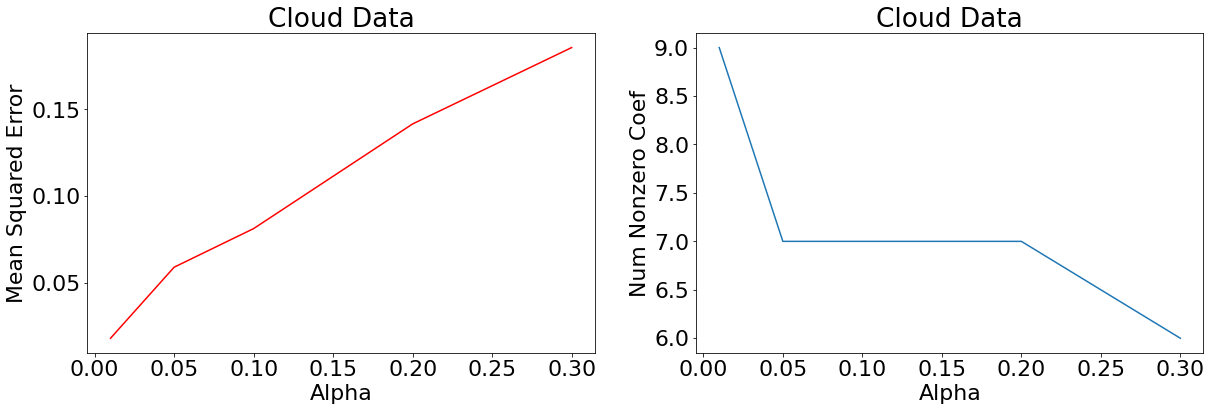

In [12]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 22})
plt.subplot(3,2,1);
plt.ylabel("Mean Squared Error") 
plt.xlabel("Alpha")
plt.title("Cloud Data")
plt.plot(alphas,result_cloud_mse,color = 'red',label="Cloud Data") 

plt.subplot(3,2,2);
plt.ylabel("Num Nonzero Coef") 
plt.xlabel("Alpha")
plt.title("Cloud Data")
plt.plot(alphas,result_cloud_coef,label="Cloud Data")


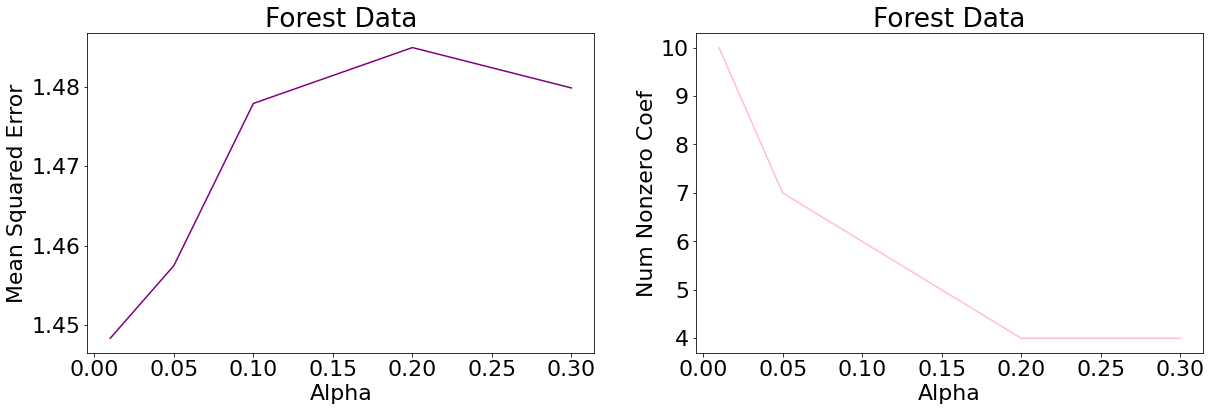

In [13]:
plt.subplot(3,2,3);
plt.ylabel("Mean Squared Error") 
plt.xlabel("Alpha")
plt.title("Forest Data")
plt.plot(alphas,result_forest_mse,color = 'purple',label="Forest Data") 

plt.subplot(3,2,4);
plt.ylabel("Num Nonzero Coef") 
plt.xlabel("Alpha")
plt.title("Forest Data")
plt.plot(alphas,result_forest_coef,color='pink',label="Forest Data")

1.5 [5 points] Compare the two algorithms on each data set: 
- Compare the number of non-zero coordinates of Ridge vs Lasso and their MSE on each dataset.
- Which type of regression is better for each dataset? 

# Workspace 1.5

Answer:

For cloud data: Ridge is better because it gives smaller MSE.

    Comparing non-zero coorinates:
       The number of non-zero coordinates of Ridge is constant as apla increases. While the number of non-zero coordinates of Lasso is decreasing as apla increases.
   
    Comparing MSE:
        The MSE is increasing as aplha inceases for both Ridge and Lasso.
        
        
For Forest data: Lasso since the MSE increase becomes very small

    Comparing non-zero coorinates:
       The number of non-zero coordinates of Ridge is constant as apla increases. While the number of non-zero coordinates of Lasso is decreasing as apla increases.
   
    Comparing MSE:
        The MSE is increasing as aplha inceases for both Ridge and Lasso. The MSE for Ridge is increasing at a constant rate while the MSE of lasso has a curve to it.
        



Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - w^Tx_i -b||^2_2 + \alpha\beta||w||_1 + \frac{\alpha}{2}(1 - \beta)||w||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

Complete the Elastic class in the same way as you completed the Ridge and Lasso class. We'll use the solver from sklearn module `ElasticNet`
([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)).
- 1.6 [5 points] Complete the `fit` and `evaluate` methods following the docstring description.

In [14]:
class Elastic:
    def __init__(self, alpha, beta=0.5):
        """
        Parameters
        ----------
        alpha:  First regularization parameter
        beta:   Second regularization parameter (default set to 0.5)        
        """                      
        self.alpha = alpha
        self.beta = beta
        self._model = linear_model.ElasticNet(alpha=alpha, l1_ratio=beta, fit_intercept=True)

    def fit(self, X, y):
        """
        Fit the Elastic model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights.
        X: training features (n_samples, n_features)
        y: target values (n_samples)
        
        RETURN :
            num_nonzero_coeff : number of non-zero coefficients in the model weights
        """
        #Workspace 1.6.a
        #BEGIN 
        #TODO: Fit the Elastic model and return the number of non-zero coefficients in the model weights.
        
        #Code here
        model = self._model.fit(X,y)
        num_nonzero_coeff=np.count_nonzero(model.coef_)

        #END
        return num_nonzero_coeff

    def evaluate(self, test_x, test_y):
        """
        Compute Mean square error (MSE) between the predicted values and the actual values  of the test data
        Parameters
        ----------
        test_x: test features
        test_y: test target

        Returns MSE
        -------
        """
        #Workspace 1.6.b
        #BEGIN
        #TODO: predict based on the test features and return the mean_squared_error        

        #Code here
        prediction=self._model.predict(test_x)
        mean_squared_error=self.mse(test_y,prediction)
        
        #END 
        return mean_squared_error

    @staticmethod
    def mse(y_true, y_hat):
        return np.mean((y_true-y_hat)**2)

In [15]:
# Tests cell
model =Elastic(1)
model.fit(cloud_data.train_x,cloud_data.train_y)
model.evaluate(cloud_data.test_x,cloud_data.test_y)

0.18957903119132283

1.7 [5 points] For each of the datasets, produce 2 plots using `Elastic` :
  - The number non-zero coefficients versus $\alpha$
  - Mean Squared Error (MSE) on test set versus $\alpha$
 
Use $\alpha = 0.01, 0.05, 0.1, 0.2, 0.3, 0,5 , 1$  and  $\beta= 0.5$.

In [16]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3]
#BEGIN Workspace 1.7

#Code here
result_cloud_mse = []
result_forest_mse= []
result_cloud_coef = []
result_forest_coef= []
#code here
for alpha in alphas:
    model = Elastic(alpha)
    
    result_cloud_coef.append(model.fit(cloud_data.train_x,cloud_data.train_y))
    result_cloud_mse.append(model.evaluate(cloud_data.test_x,cloud_data.test_y))
    
    result_forest_coef.append(model.fit(forest_data.train_x,forest_data.train_y))
    result_forest_mse.append(model.evaluate(forest_data.test_x,forest_data.test_y))

#END Workspace 1.7

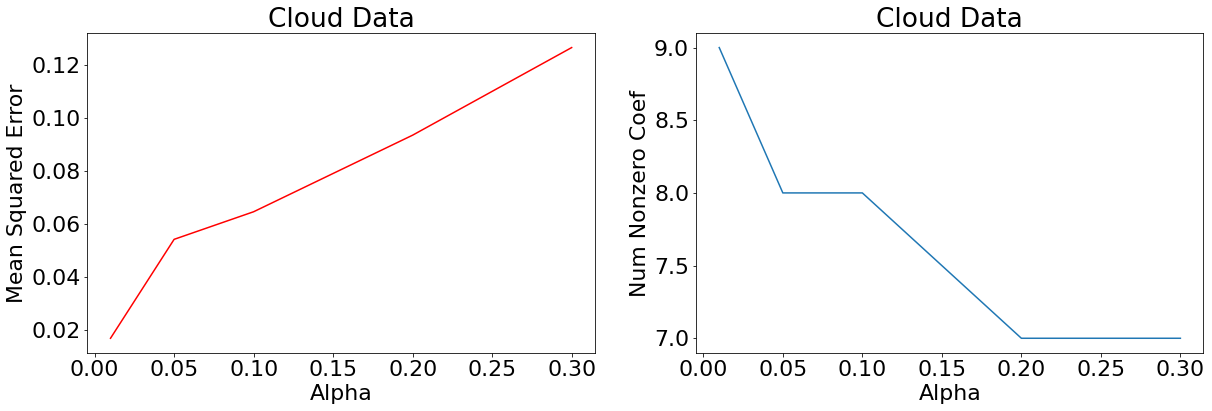

In [17]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 22})
plt.subplot(3,2,1);
plt.ylabel("Mean Squared Error") 
plt.xlabel("Alpha")
plt.title("Cloud Data")
plt.plot(alphas,result_cloud_mse,color = 'red',label="Cloud Data") 

plt.subplot(3,2,2);
plt.ylabel("Num Nonzero Coef") 
plt.xlabel("Alpha")
plt.title("Cloud Data")
plt.plot(alphas,result_cloud_coef,label="Cloud Data")

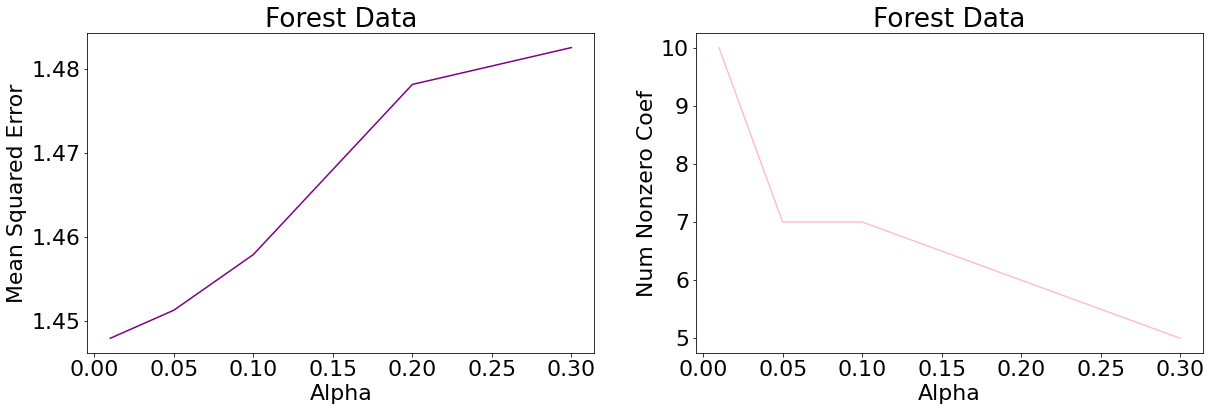

In [18]:
plt.subplot(3,2,3);
plt.ylabel("Mean Squared Error") 
plt.xlabel("Alpha")
plt.title("Forest Data")
plt.plot(alphas,result_forest_mse,color = 'purple',label="Forest Data") 

plt.subplot(3,2,4);
plt.ylabel("Num Nonzero Coef") 
plt.xlabel("Alpha")
plt.title("Forest Data")
plt.plot(alphas,result_forest_coef,color='pink',label="Forest Data")

1.8 [5 points] What are the pros and cons of each of three types of regressions we have implemented?

# Workspace 1.8
    Ridge:
       Pros: 
           1-Avoids over fitting
           2-Trades variance for bias
       Cons:
           1-Increased bias
           2-Hard to interpret the model.
        

    Lasso:
       Pros: 
           1-coefficients shrinks towards zero.
           2-Avoids over fitting
       Cons:
            1-will pick at most n features when the number of datapoints(n) is less than 
            the number  of features
           2-selected features will be bias
           3-prediction performance less than ridge
           
    Elastic:
       Pros: 
           1-unlike Lasso, has no problem picking features when the number of data 
           points is less than the number of features
       Cons:
           1-computationally expensive.
        '
        
I refrence this article: https://medium.com/@gokul.elumalai/pros-and-cons-of-common-machine-learning-algorithms-45e05423264f
        

## Problem 2: Logistic Regression for Binary Classification (45 points)
***
The second part of this assignment will be dealing with Logistic Regression. While the name "regression" suggests otherwise, Logistic Regression is actaully used for classification.
It's called regression because the model learns the continuous likelihood of multiple/a certain outcome.

Our dataset is a subset of the MNIST dataset, which is a higher resolution of the sklearn digits data seen in HW1. 

In this problem you'll implement a Logistic Regression classifier to take drawings of either an eight
or a nine and output the corresponding label.

In [58]:
class BinaryMNIST:
    """
    Class to store MNIST data for images of 9 and 8 only
    """
    def __init__(self, location='./data/mnist.pklz'):
        # You shouldn't have to modify this class, but you can if you'd like
        # Load the dataset
        with gzip.open(location, 'rb') as f:
            self.train_x, self.train_y, self.test_x, self.test_y = pickle.load(f)

        train_indices = np.where(self.train_y > 7)
        self.train_x, self.train_y = self.train_x[train_indices], self.train_y[train_indices]
        self.train_y = self.train_y - 8

        test_indices = np.where(self.test_y > 7)
        self.test_x, self.test_y = self.test_x[test_indices], self.test_y[test_indices]
        self.test_y = self.test_y - 8

binary_mnist = BinaryMNIST()

Logistic Regression is about minimizing the negative log likelihood objective is defined as:
\begin{align}
\textrm{NLL}(w) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(w^T{x_i}) + (1-y_i)\log(1 - \sigma(w^Tx_i))\right]
\end{align}
where $\sigma$ is the *sigmoid function* seen in class.

Note that we're excluding the intercept since we'll be adding a constant column to the $(x_i)_i$. 
We will call it the zero-th column and the intercept will be $w_0$.

The gradient of $NLL$ w.r.t $w$,  $\frac{\partial \textrm{NLL}}{\partial w}$

\begin{align}
\frac{\partial \textrm{NLL}}{\partial w} = \frac{1}{N} \sum_i \left[\sigma(w^Tx_i)-y_i)\right]x_i
\end{align}

- 2.1 [5 points] Finish the `calculate_score` function to return the output of applying
the dot product of the weights with the input parameter

- 2.2 [5 points] Finish the `sigmoid` function to return the output of applying the sigmoid function to the calculated score

- 2.3 [5 points] Finish the `compute_gradient` function to return the derivative of the cost w.r.t. the weights

- 2.4 [5 points] Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data and updates the weight vector correspondingly

- 2.5 [5 points] Finish the `fit` function so that it iterates over the training epochs and returns the Recall score (in-built sklearn metrics) on the validation data at the end of each epoch.

In [59]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta = 0.1):
        """
        Create a Logistic regression classifier
        :param eta: Learning rate (the default is a constant value)
        """
        self.w = [1 for x in range(len(binary_mnist.train_x[0]) +1)] # our array of weights
        self.eta = eta   # our learning rate
        self.X = binary_mnist.train_x   # features matrix
        self.y = binary_mnist.train_y   # labels / outcomes array

    def calculate_score(self, x):
        """
        :param x: This can be a single training example or it could be n training examples
        :return score: Calculate the score that you will plug into the logistic function
        """
        #Workspace 2.1
        # TODO: Compute the score to be fed to the sigmoid function
        #BEGIN
        #Code here
        score =[]
        for row in x:
            sum_total= 0
            for value_index in range(len(row)):
                sum_total = sum_total + (row[value_index] * self.w[value_index])
            score.append(sum_total)
        return score
        #END

    def sigmoid(self, score, threshold=25.0):
        """
        :param score: Either a real valued number or a vector to convert into a number between 0 and 1
        :param threshold : Capping activations at 25 prevent overflow of np.exp() function.
        :return sigmoid: Calculate the output of applying the sigmoid function to the score. This could be a single
        value or a vector depending on the input.
        """
        #BEGIN Workspace 2.2
        # TODO: Complete this function to return the output of applying the sigmoid function to the score
        #Code 
        result = []
        for i in score:
            result.append(1/(1+np.exp(-i)))
        
        return result
        #END Workspace 2.2
    
    def compute_gradient(self, x, h, y):
        """
        :param x: Feature vector
        :param h: the sigmoid of the scores computed from x
        :param y: real class label
        :return gradient: Return the derivative of the cost w.r.t to the weights
        """

        #Workspace 2.3
        # TODO: Finish this function to compute the gradient
        #BEGIN
        #Code here
        len_features = len(x[0])
        result = []
        for index_feature in range(len_features):
            total = 0
            for index_row in range(len(x)):
                total = total + (h[index_row] - y[index_row])*x[index_row][index_feature]
            result.append(total/len(x))
            
        return result
            
        #END
        
    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch. We should average the gradient over the batch size
        :param batch_x: NumPy array of features (size : size of batch X features + 1 for the intercept)
        :param batch_y: Numpy array of class labels (size : size of batch )
        :return: nothing
        """

        #Workspace 2.4
        #BEGIN
        #Code here
        scores = self.calculate_score(batch_x)
        sigmoid_scores = self.sigmoid(scores)
        gradient = self.compute_gradient(batch_x,sigmoid_scores,batch_y)
        
        for weight_index in range(len(self.w)):

            if weight_index == 0:
                continue
            self.w[weight_index] = self.w[weight_index] - (self.eta * gradient[weight_index-1])

        #END        
        
    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        :param X: training features
        :param y: training labels
        :param epochs: number of epochs
        :param batch_size: size of batch for gradient update
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: metric value at the end of each epoch on validation data
        """        
        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        # Workspace  2.5
        # TODO: Process x to append the zero-th constant column
        # TODO: Compute average recall on the validation data at the end of each epoch
        # HINT: Don't forget to initialize your weights!
        
        #add a column to X containing the value 1
        new_column = [[1] for x in range(len(X))]
        X = np.append(new_column,X, axis=1)
        for epoch in range(epochs):

            self.optimize(batch_size)
            result = []
            for row_index in range(len(validation_X)):
                #bias term
                total = self.w[0]
                for value_index in range(1,len(validation_X[row_index])):
                    total = total +(self.w[value_index] * validation_X[row_index][value_index])
                if(total >= .5):
                    result.append(1)
                else: result.append(0)
            metrics.append(recall_score(validation_y,result))
        
        return np.array(metrics)
    
    
    def predict(self, test_x):
        """
        :param test_x: n rows to predict on
        :return: n predicted labels
        """
        X = np.concatenate([np.ones((test_x.shape[0],1)), test_x], axis=1)
        return np.round(self.sigmoid(self.calculate_score(X))).astype(int)


    def optimize(self, batch_size):
        """
        Shuffle the training data (use permutation) and send batches to batch_update to update $self.w$
        Parameters
        :batch_size: size of batches to use for stochastic gradient
        :return: nothing
        """

        indices = np.random.permutation(len(self.X))
        for i in range(0, self.X.shape[0], batch_size):
            batch_x = self.X[indices[i:i+batch_size]]
            batch_y = self.y[indices[i:i+batch_size]]
            self.batch_update(batch_x, batch_y)


In [21]:
#Tests cell

In [60]:
model =LogisticRegression(0.01)
model.fit(binary_mnist.train_x, binary_mnist.train_y,10, 10, binary_mnist.test_x,binary_mnist.test_y)

array([1.   , 0.984, 0.64 , 0.672, 0.732, 0.736, 0.78 , 0.816, 0.852,
       0.884])

After completing the class above, loop over the training data and perform batch training with `batch_size = 1` for `10 epochs`, and five different values of `eta`, i.e, [$.0001, .01, .1, .5, 1$]. Train your model and do the following:

2.6 [5 points] Create a new classifier object and Using the `fit` method, plot the recall trend for the different values of eta on the training data

In [62]:
etas = [.0001,.001,.01, 1, 5]
np.random.seed(42)
time_measured = []
recalls = []
for eta in etas:
#Workspace 2.6
#BEGIN
    start = time.time()
    model =LogisticRegression(eta)
    batch_size = 1
    epoch = 10
    recalls.append(model.fit(binary_mnist.train_x, binary_mnist.train_y,epoch, batch_size, binary_mnist.test_x,binary_mnist.test_y))
    end = time.time()
    time_measured.append(end - start)
print(time_measured)
#END

[32.05111789703369, 35.82802939414978, 38.02940225601196, 34.52728343009949, 36.336098194122314]


Text(0.5, 1.0, 'trend of recall vs etas')

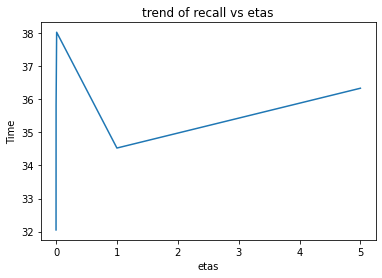

In [63]:
plt.plot(etas,time_measured,label="Trend")
plt.ylabel("Time") 
plt.xlabel("etas")
plt.title("trend of recall vs etas")


- 2.7 [5 points] Create a new classifier object and Using the `fit` method, plot the values of recall versus eta

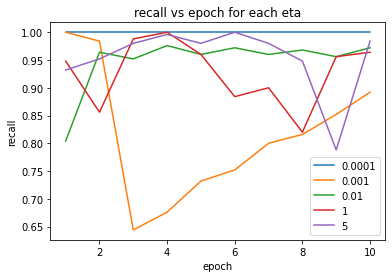

In [64]:
x = [1,2,3,4,5,6,7,8,9,10]
for i in range(5):
    plt.plot(x,recalls[i])

plt.ylabel("recall") 
plt.xlabel("epoch")
plt.title("recall vs epoch for each eta")
plt.legend(etas)

This time we want to analyze the effect of varying the batch size. We fix `eta = 0.1` and `epochs = 10` and we want to examine the recall on the test set at the end of the training for `batch_size` in [$1, 2, 4, 8, 12, 16$].

- 2.8 [5 points] Produce a plot of the recall at the end of the training as a function of the batch size

In [65]:
batch_sizes= [1, 2, 4, 8, 12, 16]
recalls = []
eta = 0.1
epoch = 10
#Workspace 2.8
#BEGIN
for batch_size in batch_sizes:
        model =LogisticRegression(eta)
        recall = model.fit(binary_mnist.train_x, binary_mnist.train_y,epoch, batch_size, binary_mnist.test_x,binary_mnist.test_y)
        end_recall =recall[9]
        recalls.append(end_recall)
#END

Text(0.5, 1.0, 'batch size vs recalls')

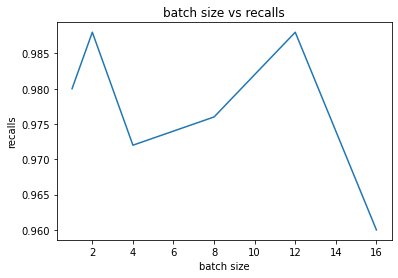

In [66]:
plt.plot(batch_sizes,recalls)
plt.ylabel("recalls") 
plt.xlabel("batch size")
plt.title("batch size vs recalls")

2.9 [5 points] How does the learning rate (`eta`) and the number of epochs affect the performance of the classifier.

# Workspace 2.9
The learning rate affect how quickly we converge to the best recall. if we have a small learning rate then it would take longer to each the best performance. and if the learning rate is large then we will reach the best performace faster but because the learning rate is large, there would be a chance to skip over the best answer.

2.BONUS [10 Points] Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(w) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(w^T{x_i}) + (1-y_i)\log(1 - \sigma(w^Tx_i))\right] + \alpha {||w||^2}
\end{align}

We will need to add an `alpha` parameter in our `LogisticRegression` class (with a default value) 

First, write the gradient formula in the cell below. Then, edit your `compute_gradient` to account for the regularization term. Ensure the rest of your functions still run correctly!

<2.BONUS Write your modified gradient formula here>

The gradient of $NLL$ w.r.t $w$,  $\frac{\partial \textrm{NLL}}{\partial w}$

\begin{align}
\frac{\partial \textrm{NLL}}{\partial w} = \frac{1}{N} \sum_i \left[\sigma(w^Tx_i)-y_i)\right]x_i + 2 \alpha ||w||
\end{align}

In [ ]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta = 0.1):
        """
        Create a Logistic regression classifier
        :param eta: Learning rate (the default is a constant value)
        """
        #add alpha
        self.a = alpha
        self.w = [1 for x in range(len(binary_mnist.train_x[0]) +1)] # our array of weights
        self.eta = eta   # our learning rate
        self.X = binary_mnist.train_x   # features matrix
        self.y = binary_mnist.train_y   # labels / outcomes array

    def calculate_score(self, x):
        """
        :param x: This can be a single training example or it could be n training examples
        :return score: Calculate the score that you will plug into the logistic function
        """
        #Workspace 2.1
        # TODO: Compute the score to be fed to the sigmoid function
        #BEGIN
        #Code here
        score =[]
        #print(x,'here')
        for row in x:
            sum_total= 0
            for value_index in range(len(row)):
                sum_total = sum_total + (row[value_index] * self.w[value_index])
            score.append(sum_total)
        return score
        #END

    def sigmoid(self, score, threshold=25.0):
        """
        :param score: Either a real valued number or a vector to convert into a number between 0 and 1
        :param threshold : Capping activations at 25 prevent overflow of np.exp() function.
        :return sigmoid: Calculate the output of applying the sigmoid function to the score. This could be a single
        value or a vector depending on the input.
        """
        #BEGIN Workspace 2.2
        # TODO: Complete this function to return the output of applying the sigmoid function to the score
        #Code 
        result = []
        for i in score:
            result.append(1/(1+np.exp(-i)))
        
        return result
        #END Workspace 2.2
    
    def compute_gradient(self, x, h, y):
        """
        :param x: Feature vector
        :param h: the sigmoid of the scores computed from x
        :param y: real class label
        :return gradient: Return the derivative of the cost w.r.t to the weights
        """

        #Workspace 2.3
        # TODO: Finish this function to compute the gradient
        #BEGIN
        #Code here
        len_features = len(x[0])
        result = []
        for index_feature in range(len_features):
            total = 0
            for index_row in range(len(x)):
                total = total + (h[index_row] - y[index_row])*x[index_row][index_feature] + (2*self.a *self.w[index_feature])
            result.append(total/len(x))
            
        return result
            
        #END
        
    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch. We should average the gradient over the batch size
        :param batch_x: NumPy array of features (size : size of batch X features + 1 for the intercept)
        :param batch_y: Numpy array of class labels (size : size of batch )
        :return: nothing
        """

        #Workspace 2.4
        #BEGIN
        #Code here
        scores = self.calculate_score(batch_x)
        sigmoid_scores = self.sigmoid(scores)
        gradient = self.compute_gradient(batch_x,sigmoid_scores,batch_y)
        
        for weight_index in range(len(self.w)):

            if weight_index == 0:
                continue
            self.w[weight_index] = self.w[weight_index] - (self.eta * gradient[weight_index-1])

        #END        
        
    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        :param X: training features
        :param y: training labels
        :param epochs: number of epochs
        :param batch_size: size of batch for gradient update
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: metric value at the end of each epoch on validation data
        """        
        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        # Workspace  2.5
        # TODO: Process x to append the zero-th constant column
        # TODO: Compute average recall on the validation data at the end of each epoch
        # HINT: Don't forget to initialize your weights!
        
        #add a column to X containing the value 1
        new_column = [[1] for x in range(len(X))]
        X = np.append(new_column,X, axis=1)
        for epoch in range(epochs):

            self.optimize(batch_size)
            result = []
            for row_index in range(len(validation_X)):
                #bias term
                total = self.w[0]
                for value_index in range(1,len(validation_X[row_index])):
                    total = total +(self.w[value_index] * validation_X[row_index][value_index])
                if(total >= .5):
                    result.append(1)
                else: result.append(0)
            metrics.append(recall_score(validation_y,result))
        
        return np.array(metrics)
    
    
    def predict(self, test_x):
        """
        :param test_x: n rows to predict on
        :return: n predicted labels
        """
        X = np.concatenate([np.ones((test_x.shape[0],1)), test_x], axis=1)
        return np.round(self.sigmoid(self.calculate_score(X))).astype(int)


    def optimize(self, batch_size):
        """
        Shuffle the training data (use permutation) and send batches to batch_update to update $self.w$
        Parameters
        :batch_size: size of batches to use for stochastic gradient
        :return: nothing
        """

        indices = np.random.permutation(len(self.X))
        for i in range(0, self.X.shape[0], batch_size):
            batch_x = self.X[indices[i:i+batch_size]]
            batch_y = self.y[indices[i:i+batch_size]]
            self.batch_update(batch_x, batch_y)
